# T-matrix computation for 3D acoustic scattering 

## Background

The infinite T-matrix can describes the acoustic scattering properties of an obstacle. In this tutorial, we will compute the T-matrix in a stable way. Consider the time-harmonic radiatiing acoustic field $u^{s}$ scattered by a three dimensional scatterer $\Omega$ in a homogeneous medium satifies the exterior Helmholtz equation: $$\Delta u^{s} + k^{2}u^{s} = 0, \ \text{in} \  \mathbb{R}^{2}\backslash\bar{\Omega},$$ where $k$ is the wavenumber and the Sommerfeld radiation condition $$\text{lim}_{|x|\rightarrow\infty}\sqrt{|x|}\left(\frac{\partial{u^{s}}}{\partial{x}} - iku^{s}\right) = 0,$$ where the limit holds uniformly in all directions $\hat{x} = x/|x|$. This scattered field is induced by the incident field $u^{i}$ via one of the four boundary conditions which corresponding four properties of the scatterer: sound-soft, sound-hard, absorbing and TM-polarized dielectric.

We can expand the incident and scattered field in terms of the wave functions which satisfy the Helmholtz eqaution. 
$$u^{i}(\boldsymbol{x}) = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}p_{q}^{p}\tilde{e_{q}^{p}}(\boldsymbol{x}),$$
$$u^{s}(\boldsymbol{x}) = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}a_{q}^{p}e_{q}^{p}(\boldsymbol{x}),$$ 
where $$\tilde{e_{q}^{p}}(\boldsymbol{x}) = j_{q}(k|\boldsymbol{x}|)Y_{q}^{p}(\hat{\boldsymbol{x}})$$ is the regular spherical wave functions and 
$$e_{q}^{p}(\boldsymbol{x}) = h_{q}^{(1)}(k|\boldsymbol{x}|)Y_{q}^{p}(\hat{\boldsymbol{x}})$$ is the radiating spherical wave functions. Here, $j_{q}$ is the spherical Bessel function of degree $q$, $h_{q}^{(1)}$ is the spherical Hankel function of degree $q$, and $Y_{q}^{p}$ is the spherical harmonic of degree $q$.

Since the Helmholtz equation is linear, there exist coefficients $t_{q'p',qp}$ such that $$a_{q'}^{p'} = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}t_{q'p',qp}p_{q}^{p}.$$ By writing $a = (a_{q}^{p})$ and $p = (p_{q}^{p})$, we define the (transition-) $T$-matrix as $T$ such that $a = Tp$. Our task is the compute this matrix using far field and the general steps are as follows.

The scattered field $u^{s}$ can be represented as $$u^{s} = Su^{i} = S\sum_{q = 0}^{\infty}\sum_{|p|\leq q}p_{q}^{p}\tilde{e_{q}^{p}}(\boldsymbol{x}) = \sum_{p = 0}^{\infty}\sum_{|p|\leq q}p_{q}^{p}S\tilde{e_{q}^{p}}(\boldsymbol{x}) = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}p_{q}^{p}u_{q}^{p},$$ where $S$ is the operator that maps the incident field to its corresponding scattered field. For example, $S\tilde{e_{q}^{p}} = u_{q}^{p}$ is the scattered field induced by $\tilde{e_{q}^{p}}$ and $$u_{q}^{p} = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}t_{q'p',qp}e_{q'}^{p'}$$. 

The far field of each $e_{q'}^{p'}$ is $e_{q'}^{p'\infty} = \frac{1}{k}(-i)^{q'+1}Y_{q'}^{p'}(\hat{\boldsymbol{x}})$, so we can write the far field of $u_{q}^{p}$ as 
$$S^{\infty}\tilde{e_{q}^{p}} = u_{q}^{p\infty} = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}t_{q'p',qp}e_{q'}^{p'\infty} = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}t_{q'p',qp}\frac{1}{k}(-i)^{q'+1}Y_{q'}^{p'}(\hat{\boldsymbol{x}})$$

By using the orthogonal property of $\text{exp}(in'\theta)$, the entries of the $T$-matrix can be expressed as 
$$t_{q'p',qp} = <u_{q}^{p\infty},Y_{q'}^{p'}>.$$

We start with the usual imports.

In [12]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import math
import matplotlib.pyplot as plt

Define the wavenumber $k$, the 3D scatterer, the vertices on the grid and function space.

In [13]:
h = 0.3 # Size of the mesh
d = [1,0,0] # wave's travel direction
k = 5 # wavenumber

unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_sphere = unit_sphere.vertices
space_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

dom_cube = bempp.api.shapes.cube(length = 2/1.8, origin=(-1/1.8,-1/1.8,-1/1.8), h = h)
vert_cube = dom_cube.vertices
space_cube = bempp.api.function_space(dom_cube,'P',1)

Here, we define the identity ($Id$), double layer ($K$) and hypersingular boundary operators ($W$). We can use then to construct the LHS of the Burton-Miller formulation: $\frac{1}{2}\text{Id} - \text{K} + \frac{i}{k}\text{W}$

In [14]:
identity = bempp.api.operators.boundary.sparse.identity(space_cube, space_cube, space_cube)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_cube, space_cube, space_cube, k)
hyp = bempp.api.operators.boundary.helmholtz.hypersingular(space_cube, space_cube, space_cube, k)

burton_miller = .5 * identity - dlp + (1j/k) * hyp

The following defines the spherical harmonic functions $Y_{q}^{p}(\hat{x})$, spherical bessel/hankel function $j_{q}(k|x|)$, $h_{q}^{(1)}(k|x|)$ and construct $\tilde{e}_{q}^{p}$ and $e_{q}^{p}$. $$Y_{q}^{p}(\hat{x}) = (-1)^{(p+|p|)/2}\sqrt{\frac{2q+1}{4\pi}\frac{(q-|p|)!}{(q+|p|)!}}P_{q}^{|p|}(\cos(\text{polar}))e^{ip*\text{azimuthal}},$$ $$j_{q}(k|x|) = \sqrt{\frac{\pi}{2k|x|}}J_{q+0.5}(k|x|),$$
$$h_{q}^{(1)}(k|x|) = \sqrt{\frac{\pi}{2k|x|}}H_{q+0.5}^{(1)}(k|x|),$$ where $\text{polar} = \arccos(\frac{x_{3}}{|x|})$ and $\text{azimuthal} = \arctan(\frac{x_{2}}{x_{1}})$.

In [7]:
def normalized_spherical_harmonics(p, q, x):
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    temp = np.array(scipy.special.lpmn(abs(p),q, np.cos(polar))[0]) 
    legd_poly = temp[-1,-1]
    return np.sqrt(((2*q+1)/(4*np.pi))*(math.factorial(q-abs(p))/math.factorial(q+abs(p))))*legd_poly*np.exp(1j*p*azimuth)
# scipy.special.lpmn will return two arrays of size (p+1, q+1) containing P_{q}^{p}(z) and its derivative for all orders from 0..p and degrees from 0..q.
# We use 'temp' to store the first row of this outpout and then choose the element in the last row and last column to be value of P_{q}^{p}.

def spherical_bessel_function(q,k,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)

def spherical_hankel_function(q,k,x):
    """Spherical hankel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.hankel1(q+0.5, k*r)

def regular_spherical_wavefunctions(p,q,k,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,k,x)*normalized_spherical_harmonics(p,q,x)

def radiating_spherical_wavefunctions(p,q,k,x):
    """Radiating Spherical Wavefunction"""
    return spherical_hankel_function(q,k,x)*normalized_spherical_harmonics(p,q,x)

We will use the formula: $(\frac{1}{2}\text{Id} - \text{K} + \frac{i}{k}\text{W})\phi = u^{i} + \frac{i}{k}\nabla u^{i}\cdot n$ to solve the scattered field $u^{s} = \mathcal{K}\phi$, where $\mathcal{K}$ is the double layer potential operator. In order to construct the normal derivative of the incident wave $\tilde{e}_{q}^{p}(x)$, we need to define the derivative of the $j_{q}$ with regard to $r = |x|$, and $Y_{q}^{p}$ with regard to polar angle and azimuthal.

We set the normal derivative of $\tilde{e_{q}^{p}}$ as 
$$\nabla{\tilde{e_{q}^{p}}}\cdot n = \left(\frac{\partial j_{q}(k|x|)}{\partial r}Y_{q}^{p}\hat{r} + \frac{1}{r}\frac{\partial Y_{q}^{p}}{\partial \text{polar}} j_{q}(k|x|)\hat{\text{polar}} + \frac{1}{r\sin(\text{polar})}\frac{\partial Y_{q}^{p}}{\partial \text{azi}} j_{q}(k|x|)\hat{\text{azi}}\right)\cdot \left(|n|\hat{r} + \arccos(\frac{n_{3}}{r})\hat{\text{polar}} + \arctan(\frac{n_{2}}{n_{1}})\hat{\text{azi}}\right) $$

$$\frac{\partial Y_{q}^{p}}{\partial \text{polar}} = |p|\cot(\text{polar})Y_{q}^{p}+\sqrt{(q-|p|)(q+|p|+1)}e^{-i*\text{azi}}Y_{q}^{p+1}$$

$$\frac{\partial Y_{q}^{p}}{\partial \text{azi}} = ipY_{q}^{p}$$

$$\frac{\partial j_{q}(z)}{\partial z} = j_{q-1}(z) - \frac{q+1}{z}j_{q}(z) \implies \frac{\partial j_{q}(k|x|)}{\partial r} = k*j_{q-1}(k|x|) - k*\frac{q+1}{k|x|}j_{q}(k*|x|)$$ 

In [8]:
def normalized_spherical_harmonics_dpolar(p, q, x):
    polar = np.arccos(x[2]/np.linalg.norm(x))
    azimuth = np.arctan2(x[1],x[0])
    y1 = normalized_spherical_harmonics(p, q, x)
    y2 = normalized_spherical_harmonics(p + 1, q, x)
    return (abs(p) / np.tan(polar)) * y1 + np.sqrt((q - abs(p)) * (q + abs(p) + 1)) * np.exp(-1j * azimuth) * y2

def normalized_spherical_harmonics_dazimuth(p, q, x):
    return 1j * p * normalized_spherical_harmonics(p, q, x)

def spherical_bessel_function_dr(q,k,x):
    r = np.linalg.norm(x)
    return k*(spherical_bessel_function(q-1,k,x) - ((q+1)/(k*r))*spherical_bessel_function(q,k,x))

Neumann function and dirichlet function of $\tilde{e}_{lj}$ and use them to construct the grid functions.

In [9]:
@bempp.api.complex_callable
def dirichlet_fun(x,n,domain_index,result):
        with objmode():
            result[0] = regular_spherical_wavefunctions(p,q,k,x)
@bempp.api.complex_callable
    def neumann_fun(x, n, domain_index, result):
        with objmode():
            r = np.linalg.norm(x)
            azimuth = np.arctan2(x[1],x[0])
            polar = np.arccos(x[2]/r)

            r_ = spherical_bessel_function_dr(q,x)*normalized_spherical_harmonics(p,q,x)
            polar_ = (1/r)*normalized_spherical_harmonics_dpolar(p,q,x)*spherical_bessel_function(q,x)
            azimuth_ = (1/(r*np.sin(polar)))*normalized_spherical_harmonics_dazimuth(p,q,x)*spherical_bessel_function(q,x)

            x0 = r_*np.sin(polar_)*np.cos(azimuth_)
            x1 = r_*np.sin(polar_)*np.sin(azimuth_)
            x2 = r_*np.cos(polar_)

            sph_to_cart = [x0, x1, x2]                      
            normal = [n[0],n[1],n[2]]

            result[0] = np.inner(sph_to_cart, normal)

In [24]:
deg = 10 # the degree of sphercial harmonic functions

mass_mat = bempp.api.operators.boundary.sparse.identity(space_sphere,space_sphere,space_sphere)

for q in range(1,deg+1):
    for p in range(-q+1,q):
        dirichlet_grid_fun = bempp.api.GridFunction(space_cube, fun = dirichlet_fun)
        neumann_grid_fun = bempp.api.GridFunction(space_cube, fun = neumann_fun)

        rhs_fun = dirichlet_grid_fun + (1j/k)*neumann_grid_fun

        total_field, info, it_count = bempp.api.linalg.gmres(burton_miller,rhs_fun,use_strong_form=True, return_iteration_count=True)
        dlp_far_field = bempp.api.operators.far_field.helmholtz.double_layer(space_sphere,vert_sphere,k)
        far_field_set.append(dlp_far_field * total_field)
        

/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/xiaoshu/.conda/envs/opencl/lib/python3.7/site-packages/pyopencl/__init__.py:235: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [25]:
T_matrix = np.zeros((deg**2,deg**2),dtype = complex)

for q in range(deg**2):
    for p in range(deg**2):
        T_matrix[q,p] = np.inner(far_field_set[p],sph_points_set[q])

### Test the T-matrix 

We set the incident wave $u^{i}$ as a plain wave $e^{ikx}$ and the first task is to expand it with respect to the basis $\tilde{e_{q}^{p}}$ and find the coefficients.

In [9]:
# need to compute coff_inc here
mass_mat = bempp.api.operators.boundary.sparse.identity(space,space,space).weak_form().A

@bempp.api.complex_callable
def inc_wave_fun(x,n,domain_index, result):
    result[0] = np.exp(1j*k*x[0])

inc_wave_grid_fun = bempp.api.GridFunction(space, fun = inc_wave_fun)

inc_wave_grid_coeff = inc_wave_grid_fun.coefficients

dirichlet_grid_coeff = []

for q in range(1,deg+1):
    for p in range(-q+1,q):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
            with objmode():
                result[0] = regular_spherical_wavefunctions(p,q,k,x)
        
        dirichlet_grid_fun = bempp.api.GridFunction(space, fun = dirichlet_fun)

        dirichlet_grid_coeff.append(dirichlet_grid_fun.coefficients)

In [10]:
coeff_inc = np.zeros(deg**2, dtype = complex)
for i in range(deg**2):
    coeff_inc[i] = inc_wave_grid_coeff.T @ mass_mat @ dirichlet_grid_coeff[i]

Use this incident wave to compute its corresponding scattered field's far field pattern

In [11]:
@bempp.api.complex_callable
def dirichlet_fun_exact(x,n,domain_index,result):
    result[0] = np.exp(1j * k * x[0])
            
@bempp.api.complex_callable
def neumann_fun_exact(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j * k * x[0])

In [12]:
dirichlet_grid_fun_exact = bempp.api.GridFunction(space, fun = dirichlet_fun_exact)
neumann_grid_fun_exact = bempp.api.GridFunction(space, fun = neumann_fun_exact)

rhs_fun_exact = dirichlet_grid_fun_exact + (1j/k)*neumann_grid_fun_exact

In [13]:
total_field_exact, info_exact, it_count_exact = bempp.api.linalg.gmres(burton_miller,rhs_fun_exact,use_strong_form=True, return_iteration_count=True)
dlp_far_field_exact = bempp.api.operators.far_field.helmholtz.double_layer(space,vert,k)
far_field_exact = dlp_far_field_exact * total_field_exact

Compute the scattered field's coefficients using the T-matrix above

In [14]:
coeff_sca = T_matrix @ coeff_inc

Use the formular $$u^{s}(\boldsymbol{x}) = \sum_{q = 0}^{\infty}\sum_{|p|\leq q}a_{q}^{p}e_{q}^{p}(\boldsymbol{x})$$ to construct scattered field 

In [15]:
def sca_wave_appro(x):
    wf_list = []
    for q in range(1,deg+1):
        for p in range(-q+1,q):
            wf_list.append((1/k)*(-1j)**(q+1)*normalized_spherical_harmonics(p,q,x))
    sca_wave_appro = np.inner(coeff_sca,wf_list)
    return sca_wave_appro

In [16]:
far_field_approx_real_part = []
for i in range(vert.shape[1]):
    far_field_approx_real_part.append(sca_wave_appro(vert[:,i]).real)

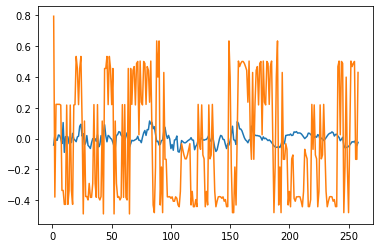

In [17]:
%matplotlib inline
x_axis = np.linspace(1,vert.shape[1],vert.shape[1])
plt.plot(x_axis,far_field_approx_real_part)
plt.plot(x_axis,np.squeeze(np.asarray(far_field_exact.real)))